In [60]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score

In [61]:
## Data Cleaning
# Get energy dummy
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

# Change constructing year to construction age and squared term for OLS.
df['age'] = 2023 - df['year']
df['age_squared'] = df['age'] ** 2

# Price per squared metre
df['price_per_m2'] = df['price'] / df['living_space']

In [62]:
## Dataset split
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'price_per_m2','area_code']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X)

      saledays  living_space  ground_space  rooms  owner_expenses  Apartment  \
0        202.0         170.0        1019.0    2.0           2.598          0   
1          0.0          94.0           0.0    3.0           2.389          1   
2        255.0         248.0         984.0    8.0           8.643          0   
3          7.0         107.0           0.0    3.0           3.849          1   
4          0.0         163.0         858.0    5.0           3.343          0   
...        ...           ...           ...    ...             ...        ...   
3645      48.0         109.0         506.0    3.0           1.922          0   
3646      48.0         117.0         800.0    3.0           1.566          0   
3647     240.0          86.0         103.0    4.0           2.184          0   
3648      48.0          79.0         829.0    3.0           1.464          0   
3649      48.0         133.0         129.0    5.0           4.615          0   

      Holiday home  Terraced house  Vil

<AxesSubplot: >

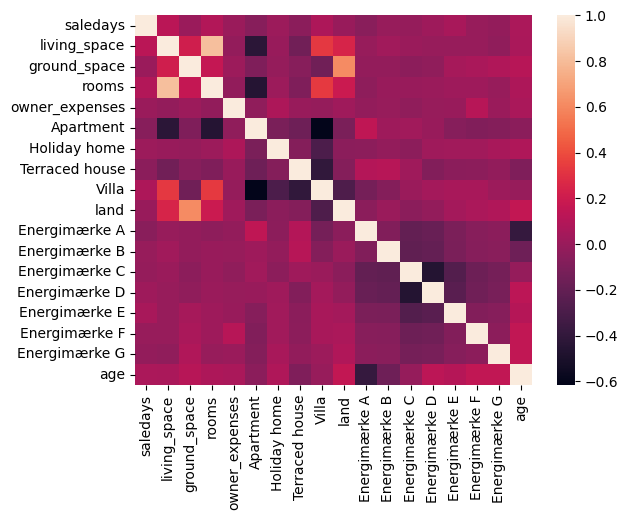

In [63]:
## Heat map
sns.heatmap(X.corr())


In [64]:
## Main model
eta = 0.1
gradient_booster = HistGradientBoostingClassifier(learning_rate=eta)
# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict = gradient_booster.predict(X_test)

# print(classification_report(y_test,y_test_predict))

In [65]:
test_accuracy = accuracy_score(y_test_predict,y_test)
test_accuracy

0.017351598173515982

In [66]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.09925478477719474

In [67]:
## Define hyperpara
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}


In [ ]:
## 10-fold cross validation
num_folds = 10
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_score = float('-inf')
best_params = {}

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        params = {
            'max_depth': max_depth,
            'learning_rate': learning_rate
        }
        
        model = HistGradientBoostingClassifier(**params)
        scores = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_squared_error')
        avg_score = np.mean(scores)
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

print("Best Parameters:", best_params)
print("Best Score:", -best_score)  # Convert back to positive mean squared error

# Fitting the model with best para
final_model = HistGradientBoostingClassifier(**best_params)
final_model.fit(X_train, y_train)

y_test_predict = final_model.predict(X_test)

In [ ]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM